### VCF parsing

In [398]:
import os
import re
import pandas as pd
import copy
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import scipy.stats as stats

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
class VariantCalls:

    def __init__(self, name):
        self.name = name
        self._calls = None
        self._readable_calls = None

    @ property
    def calls(self):
        return self._calls

    @ calls.setter
    def calls(self, table):
        self._calls = table

    @ calls.deleter
    def calls(self):
        del self._calls

    @ property
    def readable_calls(self):
        return self._readable_calls

    def make_readable(self, columns):

        table = self._calls

        for column in columns:
            match column:
                case "FILTER":
                    table = VariantCalls.by_prefiltering(table)
                case "INFO":
                    table = VariantCalls.by_info_column(table)
                case "FORMAT":
                    table = VariantCalls.by_format_column(table)
                case _:
                    raise ValueError

        self._readable_calls = table

    @ staticmethod
    def by_prefiltering(table: pd.DataFrame, select = "PASS") -> pd.DataFrame:
        # filter passing variants
    
        table = table[table.FILTER == select] 
        table.reset_index(drop=True, inplace=True)

        return table

    @ staticmethod
    def by_info_column(table: pd.DataFrame):
        # make INFO column readable; annotation

        ANNOTATION_COLUMNS = [
                      "Gencode_34_hugoSymbol",
                      "Gencode_34_ncbiBuild",
                      "Gencode_34_chromosome",
                      "Gencode_34_start",
                      "Gencode_34_end",
                      "Gencode_34_variantClassification",
                      "Gencode_34_secondaryVariantClassification",
                      "Gencode_34_variantType"
                      ]

        col = table.INFO.str.split(';', expand=True)
       
        info = col.applymap(lambda x: x.split('=')[-1] if x is not None else None)

        index_label_row = info.isnull() \
                              .sum(axis=1) \
                              .idxmin()

        info.columns = col.iloc[index_label_row,:].apply(lambda x: x.split('=')[0]).to_list()

        functional_annotation = info.FUNCOTATION.apply(lambda x: x[1:].split('|')[:8])
        functional_annotation = pd.DataFrame.from_records(functional_annotation, columns=ANNOTATION_COLUMNS)
        functional_annotation.drop(["Gencode_34_ncbiBuild","Gencode_34_chromosome"], axis=1, inplace=True)

        info.drop(["FUNCOTATION"], axis=1, inplace=True)
        
        info = pd.concat([info, functional_annotation], axis=1)

        table.drop(["INFO"], axis=1, inplace=True)
        table = pd.concat([table, info], axis=1)
       
        return table
        
    @ staticmethod
    def by_format_column(table: pd.DataFrame):
        # make FORMAT and SAMPLE column readable; counts
        
        per_variant = []
        col = table.columns.get_loc("FORMAT")
        feature_columns = range(col, col+3)

        format_columns = table.iloc[:, feature_columns].applymap(lambda x: x.split(':'))
        label, values = format_columns.iloc[:,0].to_list(), format_columns.iloc[:,1].to_list()

        for i in range(table.shape[0]):
            per_variant.append(dict(zip(label[i], values[i])))

        counts = pd.DataFrame(per_variant)

        table.drop(table.columns[feature_columns], axis=1, inplace=True)
        table = pd.concat([table, counts], axis=1)

        return table

    def calculate_variant_allele_frequency(self) -> None:
        # variant allele frequency

        self._readable_calls["VARIANT_ALLELE_FREQ"] = self._readable_calls.AD.apply(lambda x: VariantCalls.helper_get_vaf(x))
  
    @ staticmethod
    def helper_get_vaf(row: str) -> float:

        counts = row.split(',') 
        ref, alt = [int(i) for i in counts]
        
        return alt/(ref+alt)

In [4]:
class Cohort:

    def __init__(self, name, directory):
        self.name = name
        self.directory = directory
        self.cohort_calls = []

    def get_cohort_calls(self) -> None:
        
        variant_call_files = os.listdir(self.directory)
        
        for file in variant_call_files:
            filepath = self.directory + '/' + file
            table = Cohort.load_sample_calls(filepath)
            
            name = re.search(r"case-\d+", file).group()
            
            _ = VariantCalls(name)
            _.calls = table
            _.make_readable(columns=["FILTER","INFO","FORMAT"])
            _.calculate_variant_allele_frequency()
            _.readable_calls

            self.cohort_calls.append(_) 

    @ staticmethod
    def load_sample_calls(file) -> pd.DataFrame:

        with open (file) as fh:
            for i, line in enumerate(fh):
                if not line.startswith("##"):
                    skip_to_line = i
                    break

        calls = pd.read_csv(file, sep="\t", skiprows=skip_to_line)

        return calls

In [5]:
path = "/users/wuchh/downloads/updated-calls"
peac_cohort = Cohort(name="PEAC", directory="/users/wuchh/downloads/updated-calls")
peac_cohort.get_cohort_calls()

### (exact) somatic variant sites recurrently occuring in multiple samples

In [6]:
def variant_recurrence(cohort: Cohort) -> pd.Series:

    variants = []
    num_samples = len(cohort.cohort_calls)

    for i in range(num_samples):

        calls = cohort.cohort_calls[i].readable_calls

        unique_variant = calls[["#CHROM","Gencode_34_start","Gencode_34_end"]] \
                                .astype(str) \
                                .agg('_'.join, axis=1) \
                                .unique()

        variants.append(unique_variant)

    variants = itertools.chain.from_iterable(variants)
    return pd.Series(variants).value_counts()


In [81]:
def get_variant(cohort: Cohort, variant_list: list):
    # get the mutation call with annotation corresponding to its chr, start, stop
    # TODO probably a way to do this previously with finding recurrent variants

    num_samples = len(cohort.cohort_calls)
    retrieved = []

    for i in range(num_samples):

        calls = cohort.cohort_calls[i].readable_calls

        variant = calls[["#CHROM","Gencode_34_start","Gencode_34_end"]] \
                                .astype(str) \
                                .agg('_'.join, axis=1)
        
        calls_recurrent = calls[variant.isin(variant_list)]

        calls_recurrent = calls_recurrent[['#CHROM','POS',"Gencode_34_start","Gencode_34_end", 'ID', 'REF', 'ALT', 'Gencode_34_hugoSymbol','Gencode_34_variantClassification',
       'Gencode_34_secondaryVariantClassification', 'Gencode_34_variantType','VARIANT_ALLELE_FREQ']]
       
        retrieved.append(calls_recurrent)

    return pd.concat(retrieved, ignore_index=True).sort_values(by=["#CHROM", "POS"])

In [82]:
# find recurrent site
peac_reccurent_variants = variant_recurrence(peac_cohort) 
recurrent_sites = peac_reccurent_variants[peac_reccurent_variants >= 10].index.tolist() # recurrence number

# get annotations from those sites
recurrent_sites_annotated = get_variant(peac_cohort, recurrent_sites)

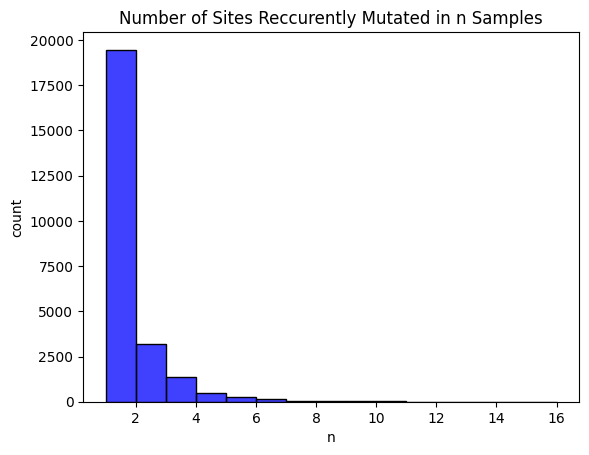

In [136]:
ax = sns.histplot(peac_reccurent_variants, color='b',binwidth=1)
ax.set(xlabel='n', ylabel='count')
ax.set_title('Number of Sites Reccurently Mutated in n Samples')
plt.show()

In [106]:
named = recurrent_sites_annotated[[
    "#CHROM","Gencode_34_start",
    "Gencode_34_end",
    "Gencode_34_hugoSymbol",
    "Gencode_34_variantClassification",
    "Gencode_34_secondaryVariantClassification",
    "Gencode_34_variantType"]] \
    .agg(':'.join, axis=1)

In [107]:
variant_recurrence_table = named.value_counts().reset_index()

In [119]:
result = pd.concat([variant_recurrence_table.iloc[:,0].str.split(':', expand=True),variant_recurrence_table.iloc[:,1]], axis=1)
result.columns = ["CHROM","Gencode_34_start","Gencode_34_end","Gencode_34_hugoSymbol","Gencode_34_variantClassification","Gencode_34_secondaryVariantClassification","Gencode_34_variantType","COUNT"]
result

,CHROM,Gencode_34_start,Gencode_34_end,Gencode_34_hugoSymbol,Gencode_34_variantClassification,Gencode_34_secondaryVariantClassification,Gencode_34_variantType,COUNT
0,chr11,124748535,124748643,VSIG2,SPLICE_SITE,INTRON,DEL,16
1,chr7,874601,874602,SUN1,THREE_PRIME_UTR,,INS,15
2,chr4,57110120,57110120,IGFBP7,MISSENSE,,SNP,15
3,chr12,55836013,55836125,MMP19,THREE_PRIME_UTR,,DEL,14
4,chr12,112013378,112013453,ERP29,COULD_NOT_DETERMINE,,DEL,14
5,chr1,24843567,24843568,CLIC4,THREE_PRIME_UTR,,INS,13
6,chrX,153794585,153794672,SSR4,SPLICE_SITE,INTRON,DEL,13
7,chr16,56609408,56609409,MT2A,THREE_PRIME_UTR,,INS,13
8,chr12,113391324,113391324,PLBD2,THREE_PRIME_UTR,,SNP,12
9,chr20,49243944,49243945,DDX27,THREE_PRIME_UTR,,INS,11


31 somatic variant sites with recurrence >= 10 samples. 30 of these are located in unique genes; MMP19 is mutated twice in two distinct sites. MMP19 is a metal metalloproteinase, involved in the breakdown of extracellular matrix components. MMP19 has been isolated as an autoantigen from the synovium of a rheumatoid arthritis patient. [MMP19 autoantigen](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjZsNWw2Zz8AhVzrHIEHbLSDjQQFnoECA8QAQ&url=https%3A%2F%2Fbmccancer.biomedcentral.com%2Farticles%2F10.1186%2Fs12885-019-5673-6&usg=AOvVaw2u27LsGeVFEPuSEhBfRC1j)

3' UTR mutations have a potential effect of altering expression because the segment regulates mRNA-based processes, such as mRNA localization, mRNA stability, and translation. [3'UTR mutations](https://cshperspectives.cshlp.org/content/11/10/a034728.full)

### (inexact) somatic variant windows recurrently occuring in multiple samples

In [138]:
variant_genes_per_sample = []
for i in range(len(peac_cohort.cohort_calls)):
    unique_in_sample = peac_cohort.cohort_calls[i].readable_calls.Gencode_34_hugoSymbol.unique().tolist()
    variant_genes_per_sample.append(unique_in_sample) # genes that are mutated at least once in a sample

genes_mutated_cohort = list(itertools.chain.from_iterable(variant_genes_per_sample))
genes_mutated_cohort_counts = pd.Series(genes_mutated_cohort).value_counts()

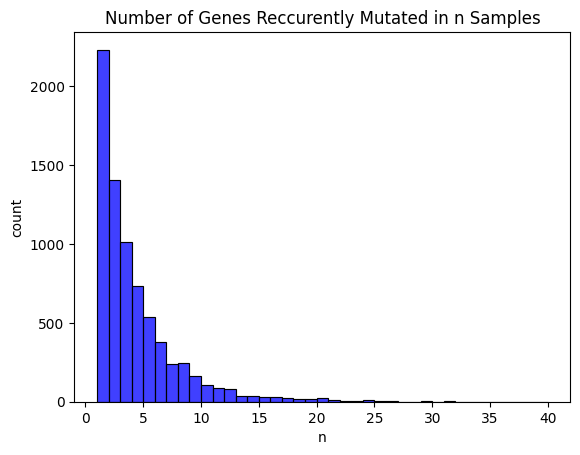

In [141]:
ax = sns.histplot(genes_mutated_cohort_counts, color='b',binwidth=1)
ax.set(xlabel='n', ylabel='count')
ax.set_title('Number of Genes Reccurently Mutated in n Samples')
plt.show()

In [140]:
genes_mutated_cohort_counts # not the same site, but within an acceptable window size, i.e., 21 base window

Unknown    40
MAVS       33
MRI1       31
SMIM14     31
MTDH       30
           ..
TMCO1       1
TIPRL       1
IP6K2       1
CIDECP1     1
VAMP7       1
Length: 7481, dtype: int64

In [70]:
# take the most recurrently mutated gene, MAVS

In [153]:
peac = peac_cohort.cohort_calls
coordinate_start = []

for sampl in range(len(peac)):
    sample_calls = peac[sampl]
    pos_mavs = sample_calls.readable_calls[sample_calls.readable_calls.Gencode_34_hugoSymbol == "MAVS"].POS.tolist()
    
    case_pos = map(lambda x: (sample_calls.name, x), pos_mavs)
    coordinate_start.append(list(case_pos))

flattened_pos_gene = list(itertools.chain.from_iterable(coordinate_start))

In [158]:
mav = pd.DataFrame.from_records(flattened_pos_gene, columns=["sample","pos_start"])

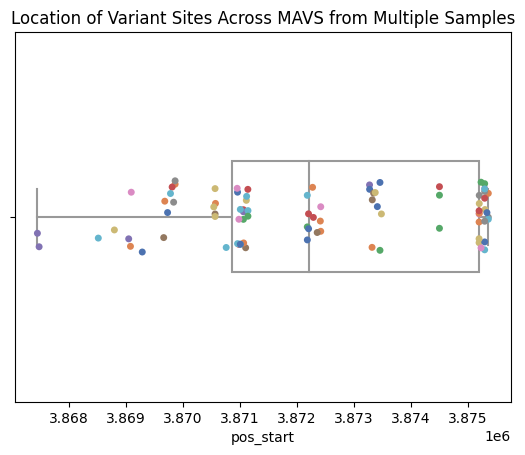

In [183]:
ax = sns.stripplot(x=mav["pos_start"], hue=mav["sample"], palette="deep")
ax = sns.boxplot(x=mav["pos_start"], boxprops={'alpha': 1}, width = 0.3, color='white')
ax.set_title('Location of Variant Sites Across MAVS from Multiple Samples')
ax.legend_.remove()

Text(0.5, 1.0, 'Variant Windows (21 nt) Across MAVS from Multiple Samples')

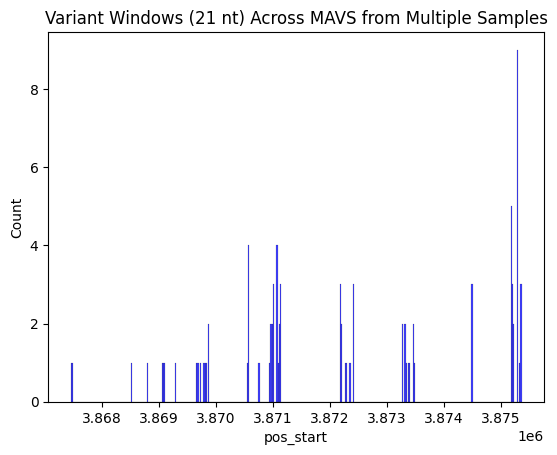

In [185]:
ax = sns.histplot(x=mav["pos_start"],binwidth=21, color='b') # not sliding window, segmented
ax.set_title('Variant Windows (21 nt) Across MAVS from Multiple Samples')

### statistical tests
chi-square test of independence between variant sites and clinical characterisitics 

wilcoxon signed rank sum, difference in VAF between different clinical groups

In [186]:
# taking recurrent variants from part A
result

,CHROM,Gencode_34_start,Gencode_34_end,Gencode_34_hugoSymbol,Gencode_34_variantClassification,Gencode_34_secondaryVariantClassification,Gencode_34_variantType,COUNT
0,chr11,124748535,124748643,VSIG2,SPLICE_SITE,INTRON,DEL,16
1,chr7,874601,874602,SUN1,THREE_PRIME_UTR,,INS,15
2,chr4,57110120,57110120,IGFBP7,MISSENSE,,SNP,15
3,chr12,55836013,55836125,MMP19,THREE_PRIME_UTR,,DEL,14
4,chr12,112013378,112013453,ERP29,COULD_NOT_DETERMINE,,DEL,14
5,chr1,24843567,24843568,CLIC4,THREE_PRIME_UTR,,INS,13
6,chrX,153794585,153794672,SSR4,SPLICE_SITE,INTRON,DEL,13
7,chr16,56609408,56609409,MT2A,THREE_PRIME_UTR,,INS,13
8,chr12,113391324,113391324,PLBD2,THREE_PRIME_UTR,,SNP,12
9,chr20,49243944,49243945,DDX27,THREE_PRIME_UTR,,INS,11


In [217]:
# clinical characteristics
clinical_characteristics = pd.read_csv("/Users/wuchh/Downloads/E-MTAB-6141_r.sdrf.txt", sep='\t')


In [256]:
# lookup by clinical characteristics
lookup_table = {}

for j in range(len(peac_cohort.cohort_calls)):

    calls_name = peac_cohort.cohort_calls[j].name
    synovial_sample_name = peac_cohort.cohort_calls[j].calls.columns[-2]

    row = clinical_characteristics[clinical_characteristics.loc[:,"Comment[GenentechID]"] == synovial_sample_name]
    select_characteristics = [i for i in row.columns if "Characteristic" in i]
    associated_characteristics = row.loc[:,select_characteristics].drop_duplicates().to_dict('records')[0]

    lookup_table[calls_name] = associated_characteristics

In [ ]:
# TODO TO SELF: figure out why the normal tumour column is reverse for sample case-50

In [262]:
characteristics_by_case = pd.DataFrame.from_dict(lookup_table).T

<AxesSubplot: xlabel='Characteristics[CCP]', ylabel='Count'>

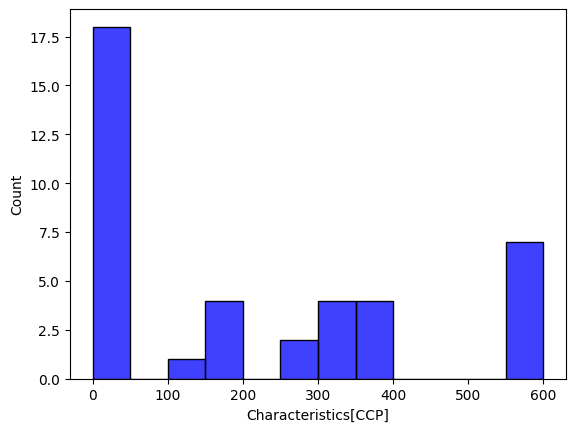

In [269]:
sns.histplot(characteristics_by_case.loc[:,"Characteristics[CCP]"], color='b', binwidth=50)

[CCP link 1](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiM2rvR7pz8AhWrElkFHYPmBCgQFnoECAsQAQ&url=https%3A%2F%2Fwww.ncbi.nlm.nih.gov%2Fpmc%2Farticles%2FPMC2911852%2F&usg=AOvVaw1GCwdAf8eJXpzQOAxvAxOr)

[CCP link 2](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiM2rvR7pz8AhWrElkFHYPmBCgQFnoECBQQAw&url=https%3A%2F%2Fpubmed.ncbi.nlm.nih.gov%2F16870095%2F&usg=AOvVaw0f1E2s96pSyJQXyCDhxRvY)

In [273]:
lowantiCCP = characteristics_by_case[characteristics_by_case.loc[:, "Characteristics[CCP]"] <= 200].index
highantiCCP = characteristics_by_case[characteristics_by_case.loc[:, "Characteristics[CCP]"] > 200].index

In [274]:
highantiCCP

Index(['case-32', 'case-5', 'case-50', 'case-34', 'case-21', 'case-2',
       'case-8', 'case-53', 'case-6', 'case-30', 'case-9', 'case-16',
       'case-17', 'case-18', 'case-15', 'case-70', 'case-65'],
      dtype='object')

In [277]:
# get indices of cases, separate by group; SORT
sort_byCCP = {"low": [], "high": []}

for i in range(len(peac_cohort.cohort_calls)):

    sample_name = peac_cohort.cohort_calls[i].name

    if sample_name in lowantiCCP:
        sort_byCCP["low"].append(i)
    elif sample_name in highantiCCP:
        sort_byCCP["high"].append(i)

In [365]:
peac_cohort.cohort_calls[i].readable_calls.columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER',
       'AS_FilterStatus', 'AS_SB_TABLE', 'DP', 'ECNT', 'GERMQ', 'MBQ', 'MFRL',
       'MMQ', 'MPOS', 'NALOD', 'NLOD', 'POPAF', 'RPA', 'RU', 'STR', 'STRQ',
       'TLOD', 'Gencode_34_hugoSymbol', 'Gencode_34_start', 'Gencode_34_end',
       'Gencode_34_variantClassification',
       'Gencode_34_secondaryVariantClassification', 'Gencode_34_variantType',
       'GT', 'AD', 'AF', 'DP', 'F1R2', 'F2R1', 'FAD', 'SB', 'PGT', 'PID', 'PS',
       'VARIANT_ALLELE_FREQ'],
      dtype='object')

In [457]:
# get variants for each group; by exact site

vafs_in_group = {"low": None, "high": None}

for z in vafs_in_group.keys():

    samples_in_group = []

    for i in sort_byCCP[z]:

        variant_id = peac_cohort.cohort_calls[i].readable_calls.loc[:, ['#CHROM','ALT','Gencode_34_hugoSymbol', 'Gencode_34_start', 'Gencode_34_end']].astype(str).agg(':'.join,axis=1)
        vaf = peac_cohort.cohort_calls[i].readable_calls.VARIANT_ALLELE_FREQ

        sample_vaf = pd.concat([variant_id,vaf], axis=1)
        sample_vaf.columns = ["variant","vaf"]
        samples_in_group.append(sample_vaf)

    group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
    group_variants.set_index("variant", inplace=True)

    vafs_in_group[z] = group_variants

/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2253444525.py:18: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2253444525.py:18: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2253444525.py:18: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var

In [458]:
vafs_in_group["low"].columns = lowantiCCP
vafs_in_group["high"].columns = highantiCCP

vafs_in_group["low"].drop_duplicates(keep=False, inplace=True)
vafs_in_group["high"].drop_duplicates(keep=False, inplace=True)

overlapping_variant_sites = set(vafs_in_group["low"].index).intersection(set(vafs_in_group["high"].index))

low = vafs_in_group["low"].reindex(overlapping_variant_sites)
high = vafs_in_group["high"].reindex(overlapping_variant_sites)

low_aszero, high_aszero = low.fillna(0), high.fillna(0)

low_vafs, high_vafs = list(low_aszero.iterrows()), list(high_aszero.iterrows())

In [459]:
p_values = []

if len(low_vafs) == len(high_vafs):
    num_rows = len(low_vafs)

    for i in range(num_rows):
        test_statistic, p_value = stats.mannwhitneyu(low_vafs[i][1], high_vafs[i][1], alternative='two-sided')
        p_values.append(p_value)

In [460]:
mean_vafs = pd.concat([low.mean(axis=1),high.mean(axis=1)], axis=1)
mean_vafs.columns = ["low CCP", "high CCP"]
mean_vafs["p_values"] = p_values

In [462]:
mean_vafs.sort_values("p_values", ascending=True)

,low CCP,high CCP,p_values
variant,,,
chr6:GA:TSPYL1:116276837:116276838,0.092105,0.045238,0.042802
chr11:TA:CTNND1:57818279:57818280,0.019672,0.030142,0.063329
chr21:CT:SUMO3:44806081:44806082,0.026415,0.048187,0.063329
chr16:TA:VKORC1:31090956:31090957,0.007529,0.048638,0.063329
chr13:AT:LATS2:20973282:20973283,0.070588,0.132419,0.063329
...,...,...,...
chr14:TA:SEC23A:39032543:39032544,0.062247,0.095517,1.000000
chr1:AT:SNHG12:28578604:28578605,0.128343,0.170792,1.000000
chr21:AT:BTG3:17594192:17594193,0.066357,0.115123,1.000000


In [439]:
# get variants for each group; by gene

for z in vafs_in_group.keys():

    samples_in_group = []

    for i in sort_byCCP[z]:

        variant_id = peac_cohort.cohort_calls[i].readable_calls.loc[:, ['Gencode_34_hugoSymbol']]
        vaf = peac_cohort.cohort_calls[i].readable_calls.VARIANT_ALLELE_FREQ

        sample_vaf = pd.concat([variant_id,vaf], axis=1)

     
        sample_vaf = sample_vaf.groupby("Gencode_34_hugoSymbol").mean() # take mean within a sample
        sample_vaf.reset_index(inplace=True)

        sample_vaf.columns = ["variant","vaf"]
        samples_in_group.append(sample_vaf)

    group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
    group_variants.set_index("variant", inplace=True)

    vafs_in_group[z] = group_variants

/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2783767797.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2783767797.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var/folders/_k/0wd_frsd3dg1x487y924q979_83jn9/T/ipykernel_23628/2783767797.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vaf_x'} in the result is deprecated and will raise a MergeError in a future version.
  group_variants = reduce(lambda x,y: pd.merge(x,y, on='variant', how='outer'), samples_in_group)
/var

In [441]:
vafs_in_group["low"].columns = lowantiCCP
vafs_in_group["high"].columns = highantiCCP

vafs_in_group["low"].drop_duplicates(keep=False, inplace=True)
vafs_in_group["high"].drop_duplicates(keep=False, inplace=True)

overlapping_variant_sites = set(vafs_in_group["low"].index).intersection(set(vafs_in_group["high"].index))

low = vafs_in_group["low"].reindex(overlapping_variant_sites)
high = vafs_in_group["high"].reindex(overlapping_variant_sites)

low_aszero, high_aszero = low.fillna(0), high.fillna(0)

low_vafs, high_vafs = list(low_aszero.iterrows()), list(high_aszero.iterrows())

In [442]:
p_values = []

if len(low_vafs) == len(high_vafs):
    num_rows = len(low_vafs)

    for i in range(num_rows):
        test_statistic, p_value = stats.mannwhitneyu(low_vafs[i][1], high_vafs[i][1], alternative='two-sided')
        p_values.append(p_value)

In [455]:
mean_vafs = pd.concat([low.mean(axis=1),high.mean(axis=1)], axis=1)
mean_vafs.columns = ["low CCP", "high CCP"]
mean_vafs["p_values"] = p_values

In [456]:
mean_vafs.sort_values("p_values", ascending=True)

,low CCP,high CCP,p_values
variant,,,
MAF,0.023359,0.151504,0.001057
CNN2,0.097222,0.554575,0.010398
ANKRD13D,0.100000,0.340087,0.010431
GLG1,0.100606,0.072349,0.012357
PRKAA1,0.111860,0.043143,0.015814
...,...,...,...
SGSH,0.116151,0.093913,1.000000
BECN1,0.068910,0.625000,1.000000
PPM1A,0.406816,0.351351,1.000000


[autoantigens](https://pubmed.ncbi.nlm.nih.gov/15511669/)

In [ ]:
# window
# chi-square (has or does not have mutation, with category of interest)
# regression 
# dN/dS
# is overall mutational burden associated with inflammation
# is a mutation in a gene make it more likely that other mutations will appear in the same gene?

# autoantigens through non-mutational mechanism, e.g., post-translational modification; made more aggressive thorugh alterations in expression (mass action: more targets, more autoantigens)?

# underlying assumption that (1) early in RA there has not been sufficent time to acquire mutations (2) exact point mutations are not needed, just overlapping in window (degenerate binding interactions, etc)